# Preamble

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pet_cli.tcms_as_convolutions as pet_tcms
import pet_cli.tac_interpolation as pet_interp

sns.set()
sns.set_style("ticks")
sns.set_context("talk")
plt.rcParams['font.family'] ='StixGeneral'
plt.rcParams['mathtext.fontset'] = 'stix'

PET Processing Package


# Getting FDG Input Function And Interpolating

In [2]:
input_function = np.loadtxt("turku_pet_center_fdg_plasma_clamp.txt", skiprows=1).T

In [3]:
interp_input_woMax = pet_interp.EvenlyInterpolate(*input_function, delta_time=0.5).get_resampled_tac()

In [4]:
interp_input = pet_interp.EvenlyInterpolateWithMax(*input_function, samples_before_max=5).get_resampled_tac()

## Plotting

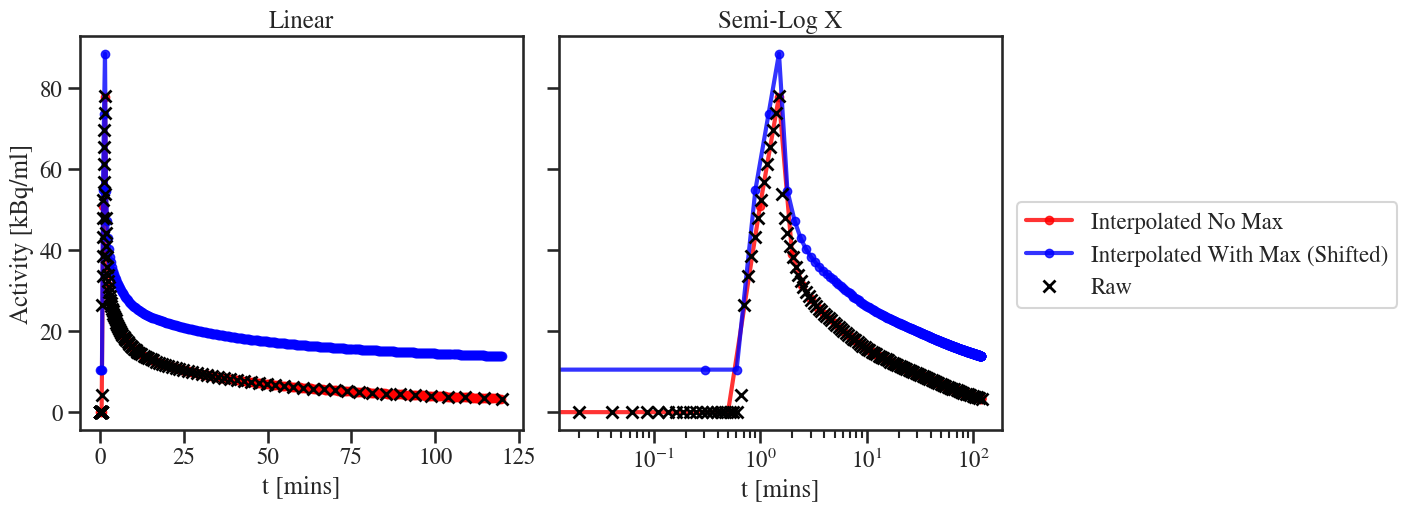

In [5]:
myFig, myAx = plt.subplots(1,2, figsize=[10,5], constrained_layout=True, sharey=True)
for anAx in myAx.flatten():
    anAx.plot(interp_input_woMax[0], interp_input_woMax[1], '.-', 
              label='Interpolated No Max', color='red', lw=3, alpha=0.8, ms=12)
    anAx.plot(interp_input[0], interp_input[1]+10.5, '.-', 
              label='Interpolated With Max (Shifted)', color='blue', lw=3, alpha=0.8, ms=12)
    anAx.plot(*input_function, 'x', label='Raw', color='black', mew=2)
    
myAx[0].set(ylabel="Activity [kBq/ml]", xlabel='t [mins]', title='Linear')
myAx[1].set(xscale="log", xlabel='t [mins]', title='Semi-Log X')
myFig.legend(*myAx[0].get_legend_handles_labels(), bbox_to_anchor=(1.0, 0.5), loc='center left')
plt.savefig(f"fdg_plasma_clamp_tacs.png", bbox_inches='tight', dpi=72)
plt.savefig(f"fdg_plasma_clamp_tacs.pdf", bbox_inches='tight')
plt.show()

# 1 TCM

## Plotting Examples

In [7]:
def tcm_1tcm_label(k1, k2):
    return fr"$k_{{1}}={k1:<3.2f};\, k_{{2}}={k2:<3.2f}$"

In [8]:
TCM_1TCM_VALS_KVALS = [[1.0, 0.25], [0.25, 1.0]]

### Noise Free

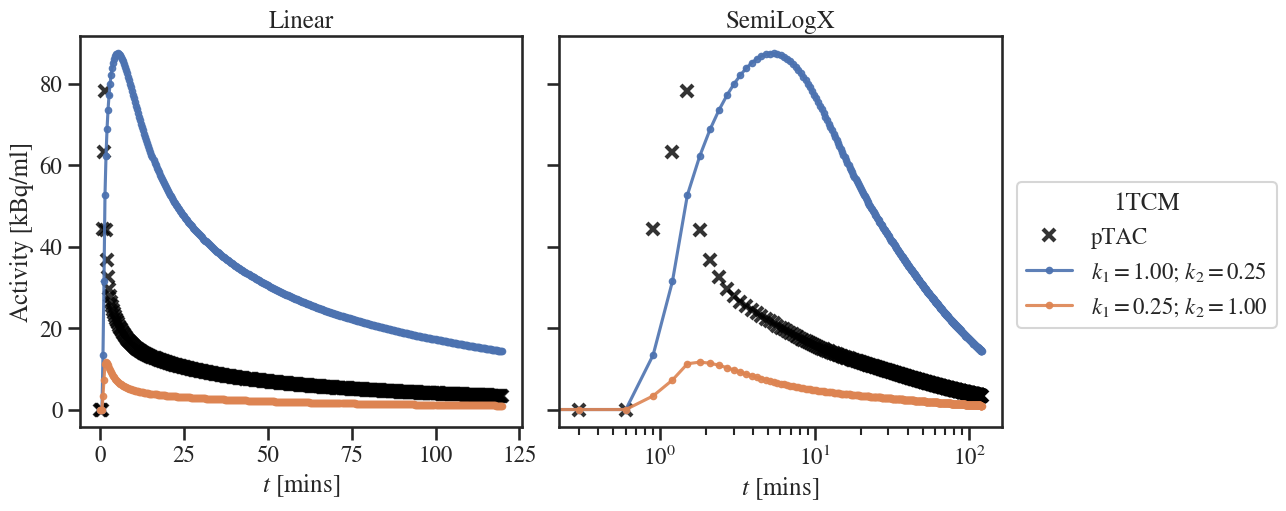

In [9]:
myFig, myAx = plt.subplots(1,2, figsize=[10,5], constrained_layout=True, sharey=True)
for anAx in myAx.flatten():
    anAx.plot(*interp_input, 'x', label='pTAC', color='black', alpha=0.8, mew=3)
    for (k1, k2) in zip(*TCM_1TCM_VALS_KVALS):
        tcm_tac = pet_tcms.generate_tac_1tcm_c1_from_tac(*interp_input, k1=k1, k2=k2)
        anAx.plot(*tcm_tac, '.-', alpha=0.9, label=tcm_1tcm_label(k1, k2))
myAx[0].set(ylabel="Activity [kBq/ml]", xlabel='$t$ [mins]', title='Linear')
myAx[1].set(xscale="log", xlabel='$t$ [mins]', title='SemiLogX')
myFig.legend(*myAx[0].get_legend_handles_labels(), bbox_to_anchor=(1.0, 0.5), loc='center left', title='1TCM')
plt.savefig(f"1tcm/noise_free/tacs.png", bbox_inches='tight', dpi=72)
plt.savefig(f"1tcm/noise_free/tacs.pdf", bbox_inches='tight')
plt.show()

### Gaussian Noise

Adding Gaussian noise where 
$$
\sigma = \frac{\int_0^{T}C_\mathrm{P}(t)\mathrm{d}t}{T},
$$
or the average value of the pTAC used for generating the tTACs.

In [10]:
noise_level = np.trapz(x=interp_input[0], y=interp_input[1])/len(interp_input[0])

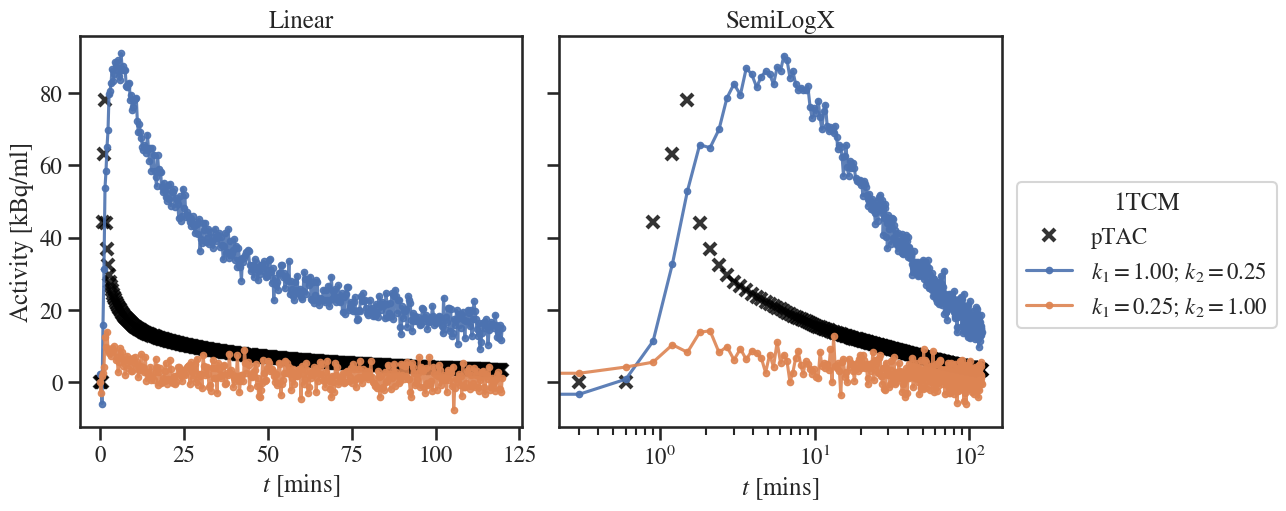

In [11]:
myFig, myAx = plt.subplots(1,2, figsize=[10,5], constrained_layout=True, sharey=True)
for anAx in myAx.flatten():
    anAx.plot(*interp_input, 'x', label='pTAC', color='black', alpha=0.8, mew=3)
    for (k1, k2) in zip(*TCM_1TCM_VALS_KVALS):
        tcm_tac = pet_tcms.generate_tac_1tcm_c1_from_tac(*interp_input, k1=k1, k2=k2)
        tcm_tac[1] += np.random.normal(loc=0.0, scale=noise_level, size=len(tcm_tac[1]))
        anAx.plot(*tcm_tac, '.-', alpha=0.9, label=tcm_1tcm_label(k1, k2))
myAx[0].set(ylabel="Activity [kBq/ml]", xlabel='$t$ [mins]', title='Linear')
myAx[1].set(xscale="log", xlabel='$t$ [mins]', title='SemiLogX')
myFig.legend(*myAx[0].get_legend_handles_labels(), bbox_to_anchor=(1.0, 0.5), loc='center left', title='1TCM')
plt.savefig(f"1tcm/gaussian_noise/tacs.png", bbox_inches='tight', dpi=72)
plt.savefig(f"1tcm/gaussian_noise/tacs.pdf", bbox_inches='tight')
plt.show()

## Writing To Disk

In [14]:
def param_writer(kVals):
    tmp = []
    for vID, val in enumerate(kVals):
        tmp.append(f'k{vID+1}:{val:.2f}')
    return "; ".join(tmp)

for kID, kVals in enumerate(zip(*TCM_1TCM_VALS_KVALS)):
    print(param_writer(kVals))

k1:1.00; k2:0.25
k1:0.25; k2:1.00


### Noise Free

In [15]:
for pID, kVals in enumerate(zip(*TCM_1TCM_VALS_KVALS)):
    tcm_tac = pet_tcms.generate_tac_1tcm_c1_from_tac(*interp_input, *kVals)
    np.savetxt(f"1tcm/noise_free/tac_1tcm_set-{pID:02}.txt", 
               fmt='%.6e',
               X=tcm_tac.T, 
               header=f"1TCM with {param_writer(kVals)}\nTimes[minutes] Activity[kBq/ml]")


### Gaussian Noise

In [17]:
for pID, kVals in enumerate(zip(*TCM_1TCM_VALS_KVALS)):
    tcm_tac = pet_tcms.generate_tac_1tcm_c1_from_tac(*interp_input, *kVals)
    tcm_tac[1] += np.random.normal(loc=0.0, scale=noise_level, size=len(tcm_tac[1]))
    np.savetxt(f"1tcm/gaussian_noise/tac_1tcm_set-{pID:02}.txt", 
               fmt='%.6e',
               X=tcm_tac.T, 
               header=f"1TCM with {param_writer(kVals)}\nTimes[minutes] Activity[kBq/ml]")


# 2TCM With $k_{4}=0$

In [18]:
def tcm_2tcm_label(k1, k2, k3, k4=0.0):
    if k4 == 0.0:
        return fr"$k_{{1}}={k1:<3.2f};\, k_{{2}}={k2:<3.2f};\, k_{{3}}={k3:<3.2f}$"
    else:
        return fr"$k_{{1}}={k1:<3.2f};\, k_{{2}}={k2:<3.2f};\, k_{{3}}={k3:<3.2f};\, k_{{4}}={k4:<3.2f}$"

## Plotting Examples

### $C_1$

In [19]:
TCM_2TCM_VALS_KVALS =[[0.5, 0.5], [0.5, 0.5], [0.01, 0.25]]

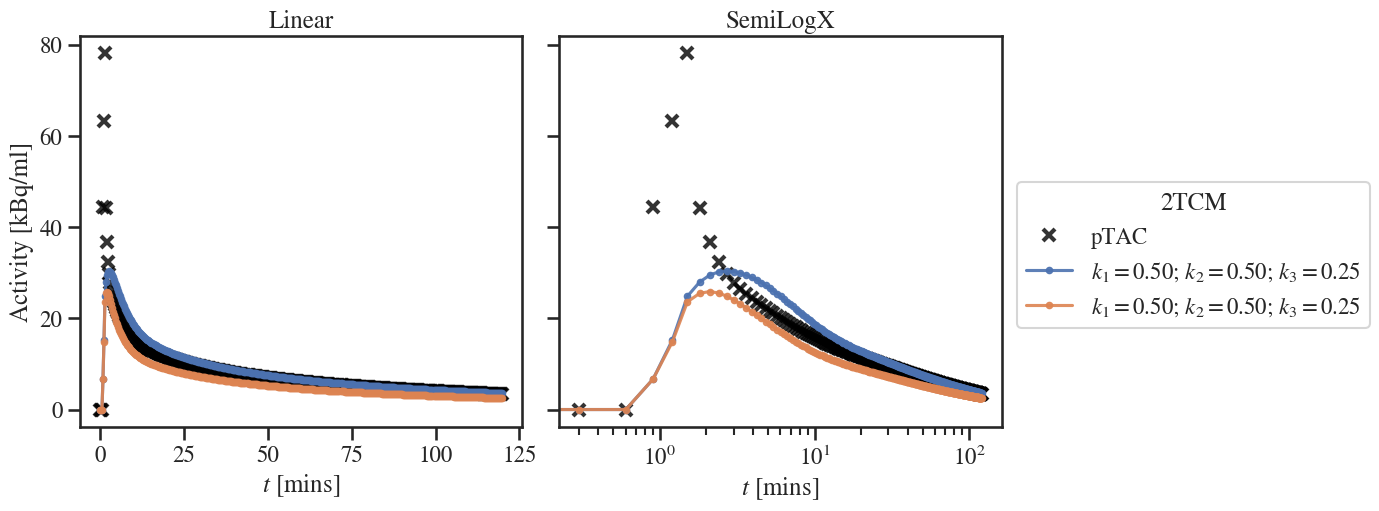

In [23]:
myFig, myAx = plt.subplots(1,2, figsize=[10,5], constrained_layout=True, sharey=True)
for anAx in myAx.flatten():
    anAx.plot(*interp_input, 'x', label='pTAC', color='black', alpha=0.8, mew=3)
    for kID, kVals in enumerate(zip(*TCM_2TCM_VALS_KVALS)):
        tcm_tac = pet_tcms.generate_tac_2tcm_with_k4zero_c1_from_tac(*interp_input, *kVals)
        anAx.plot(*tcm_tac, '.-', alpha=0.9, label=tcm_2tcm_label(k1, k2, k3))
myAx[0].set(ylabel="Activity [kBq/ml]", xlabel='$t$ [mins]', title='Linear')
myAx[1].set(xscale="log", xlabel='$t$ [mins]', title='SemiLogX')
myFig.legend(*myAx[0].get_legend_handles_labels(), bbox_to_anchor=(1.0, 0.5), loc='center left', title='2TCM')
plt.show()

### $C_2$

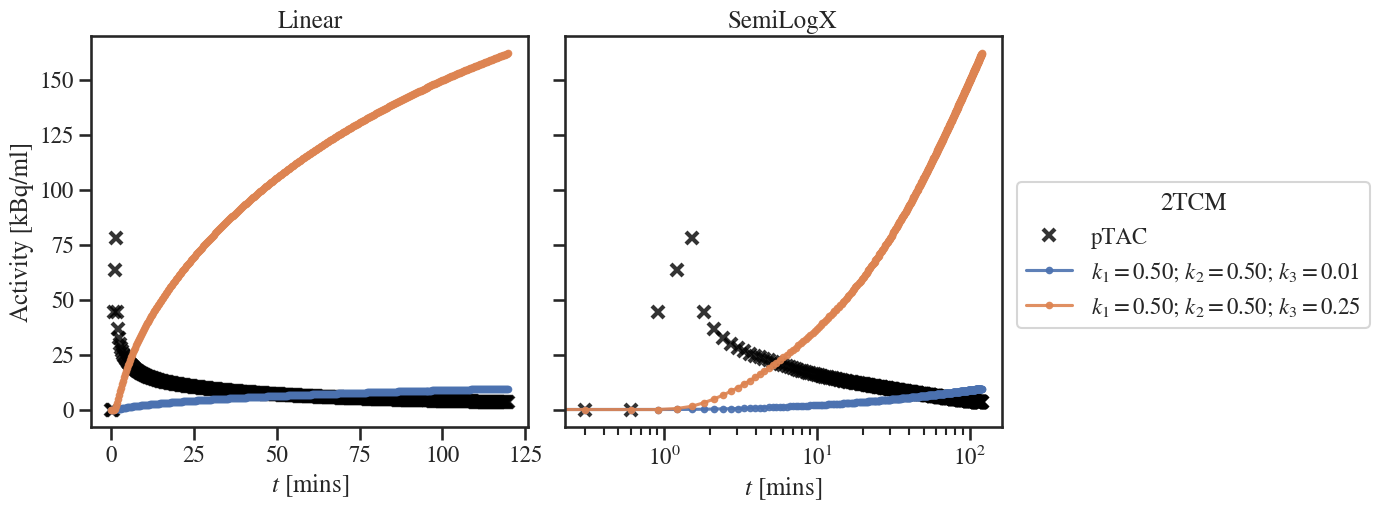

In [22]:
myFig, myAx = plt.subplots(1,2, figsize=[10,5], constrained_layout=True, sharey=True)
for anAx in myAx.flatten():
    anAx.plot(*interp_input, 'x', label='pTAC', color='black', alpha=0.8, mew=3)
    for kID, kVals in enumerate(zip(*TCM_2TCM_VALS_KVALS)):
        tcm_tac = pet_tcms.generate_tac_2tcm_with_k4zero_c2_from_tac(*interp_input, *kVals)
        anAx.plot(*tcm_tac, '.-', alpha=0.9, label=tcm_2tcm_label(*kVals))
myAx[0].set(ylabel="Activity [kBq/ml]", xlabel='$t$ [mins]', title='Linear')
myAx[1].set(xscale="log", xlabel='$t$ [mins]', title='SemiLogX')
myFig.legend(*myAx[0].get_legend_handles_labels(), bbox_to_anchor=(1.0, 0.5), loc='center left', title='2TCM')
plt.show()

### $C_\mathrm{PET}$

#### Noise Free

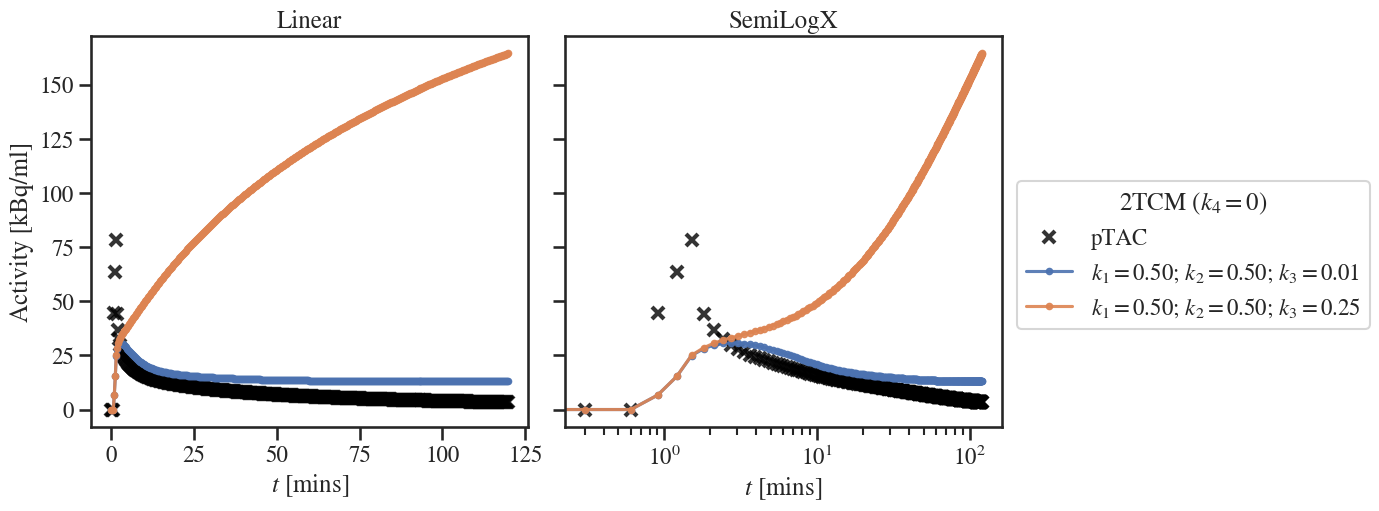

In [25]:
myFig, myAx = plt.subplots(1,2, figsize=[10,5], constrained_layout=True, sharey=True)
for anAx in myAx.flatten():
    anAx.plot(*interp_input, 'x', label='pTAC', color='black', alpha=0.8, mew=3)
    for kID, kVals in enumerate(zip(*TCM_2TCM_VALS_KVALS)):
        tcm_tac = pet_tcms.generate_tac_2tcm_with_k4zero_cpet_from_tac(*interp_input, *kVals)
        anAx.plot(*tcm_tac, '.-', alpha=0.9, label=tcm_2tcm_label(*kVals))
myAx[0].set(ylabel="Activity [kBq/ml]", xlabel='$t$ [mins]', title='Linear')
myAx[1].set(xscale="log", xlabel='$t$ [mins]', title='SemiLogX')
myFig.legend(*myAx[0].get_legend_handles_labels(), bbox_to_anchor=(1.0, 0.5), loc='center left', title=r'2TCM ($k_4=0$)')
plt.savefig(f"serial_2tcm_k4zero/noise_free/tacs.png", bbox_inches='tight', dpi=72)
plt.savefig(f"serial_2tcm_k4zero/noise_free/tacs.pdf", bbox_inches='tight')
plt.show()

#### Gaussian Noise

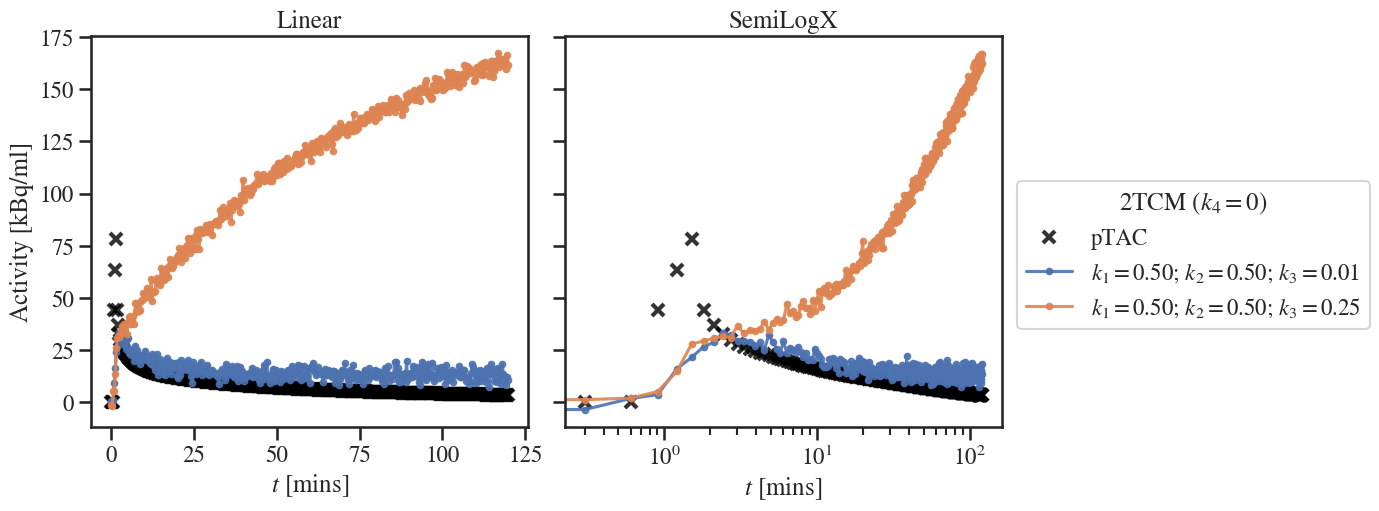

In [26]:
myFig, myAx = plt.subplots(1,2, figsize=[10,5], constrained_layout=True, sharey=True)
for anAx in myAx.flatten():
    anAx.plot(*interp_input, 'x', label='pTAC', color='black', alpha=0.8, mew=3)
    for kID, kVals in enumerate(zip(*TCM_2TCM_VALS_KVALS)):
        tcm_tac = pet_tcms.generate_tac_2tcm_with_k4zero_cpet_from_tac(*interp_input, *kVals)
        tcm_tac[1] += np.random.normal(loc=0.0, scale=noise_level, size=len(tcm_tac[1]))
        anAx.plot(*tcm_tac, '.-', alpha=0.9, label=tcm_2tcm_label(*kVals))
myAx[0].set(ylabel="Activity [kBq/ml]", xlabel='$t$ [mins]', title='Linear')
myAx[1].set(xscale="log", xlabel='$t$ [mins]', title='SemiLogX')
myFig.legend(*myAx[0].get_legend_handles_labels(), bbox_to_anchor=(1.0, 0.5), loc='center left', title=r'2TCM ($k_4=0$)')
plt.savefig(f"serial_2tcm_k4zero/gaussian_noise/tacs.png", bbox_inches='tight', dpi=72)
plt.savefig(f"serial_2tcm_k4zero/gaussian_noise/tacs.pdf", bbox_inches='tight')
plt.show()

### $\partial_{t}C_\mathrm{PET}$

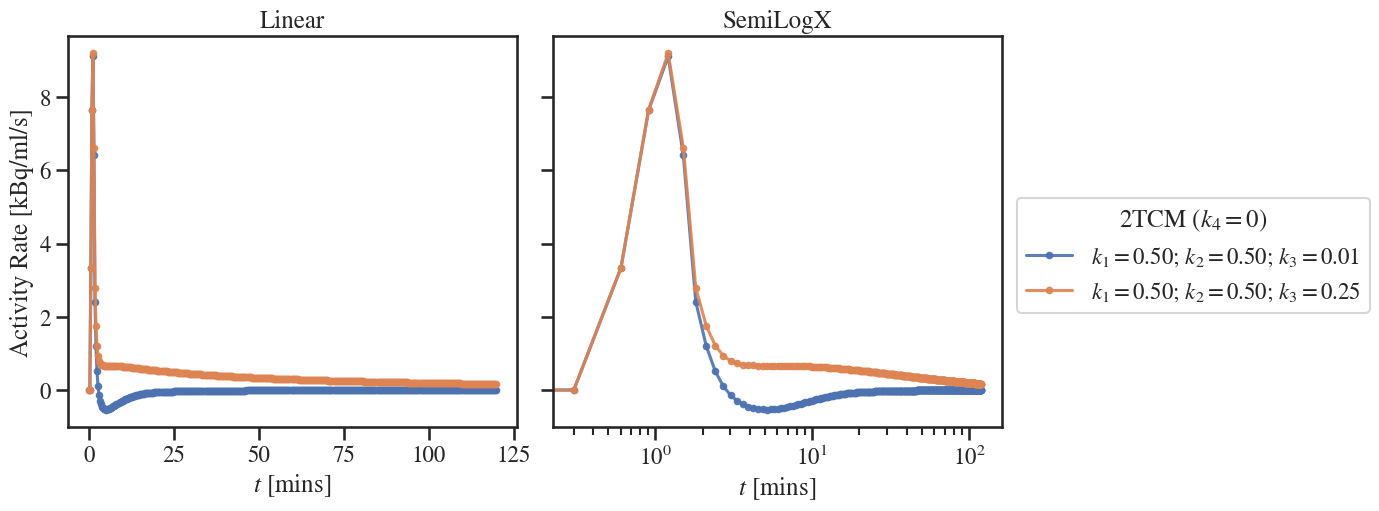

In [27]:
myFig, myAx = plt.subplots(1,2, figsize=[10,5], constrained_layout=True, sharey=True)
for anAx in myAx.flatten():
#     anAx.plot(*interp_input, 'x', label='pTAC', color='black', alpha=0.8, mew=3)
    for kID, kVals in enumerate(zip(*TCM_2TCM_VALS_KVALS)):
        tcm_tac = pet_tcms.generate_tac_2tcm_with_k4zero_cpet_from_tac(*interp_input, *kVals)
#         tcm_tac[1] += np.random.normal(loc=0.0, scale=noise_level, size=len(tcm_tac[1]))
        anAx.plot(tcm_tac[0], np.gradient(tcm_tac[1]), '.-', alpha=0.9, label=tcm_2tcm_label(*kVals))
myAx[0].set(ylabel="Activity Rate [kBq/ml/s]", xlabel='$t$ [mins]', title='Linear')
myAx[1].set(xscale="log", xlabel='$t$ [mins]', title='SemiLogX')
myFig.legend(*myAx[0].get_legend_handles_labels(), bbox_to_anchor=(1.0, 0.5), loc='center left', title=r'2TCM ($k_4=0$)')
plt.show()

## Writing To Disk

### Noise Free

In [28]:
for pID, kVals in enumerate(zip(*TCM_2TCM_VALS_KVALS)):
    tcm_tac = pet_tcms.generate_tac_2tcm_with_k4zero_cpet_from_tac(*interp_input, *kVals)
    np.savetxt(f"serial_2tcm_k4zero/noise_free/tac_2tcm_k4zero_set-{pID:02}.txt", 
               fmt='%.6e',
               X=tcm_tac.T, 
               header=f"Serial 2TCM (k4=0) with {param_writer(kVals)}\nTimes[minutes] Activity[kBq/ml]")


## Gaussian Noise

In [29]:
for pID, kVals in enumerate(zip(*TCM_2TCM_VALS_KVALS)):
    tcm_tac = pet_tcms.generate_tac_2tcm_with_k4zero_cpet_from_tac(*interp_input, *kVals)
    tcm_tac[1] += np.random.normal(loc=0.0, scale=noise_level, size=len(tcm_tac[1]))
    np.savetxt(f"serial_2tcm_k4zero/gaussian_noise/tac_2tcm_k4zero_set-{pID:02}.txt",
               fmt='%.6e',
               X=tcm_tac.T, 
               header=f"Serial 2TCM (k4=0) with {param_writer(kVals)}\nTimes[minutes] Activity[kBq/ml]")


# Full Serial 2TCM

## Plotting Examples

In [30]:
TCM_FULL_2TCM_VALS_KVALS = [[0.5, 0.5, 0.5],
                            [0.85, 0.85, 0.85],
                            [0.01, 0.25, 0.25],
                            [0.01, 0.01, 0.15]]

### $C_1$

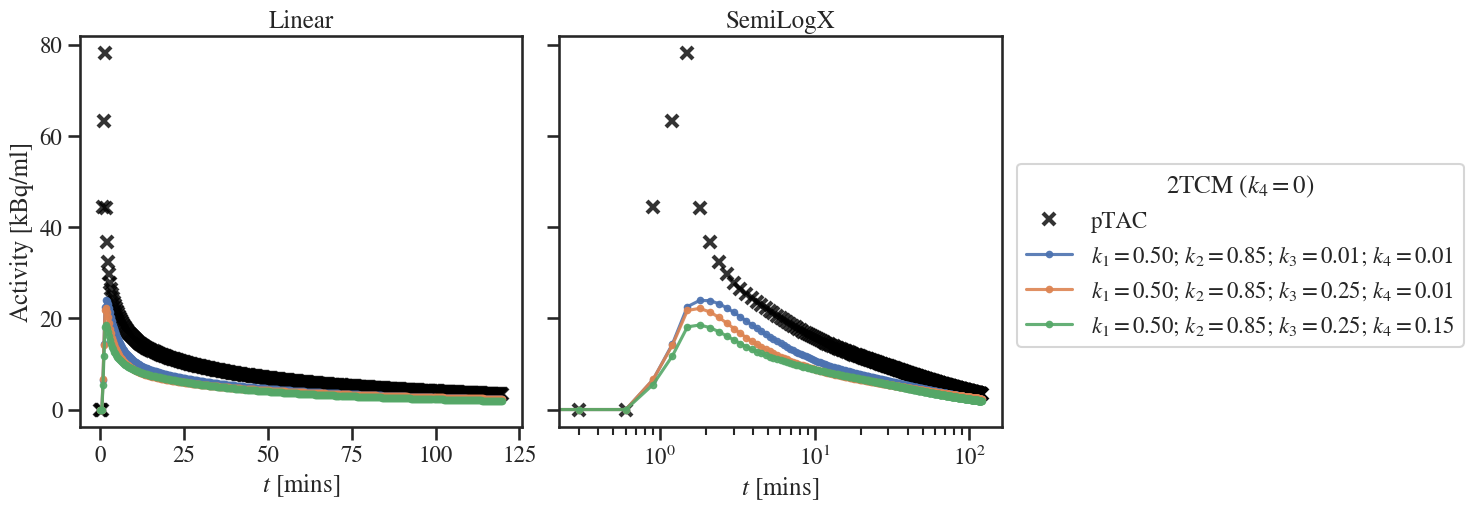

In [31]:
myFig, myAx = plt.subplots(1,2, figsize=[10,5], constrained_layout=True, sharey=True)
for anAx in myAx.flatten():
    anAx.plot(*interp_input, 'x', label='pTAC', color='black', alpha=0.8, mew=3)
    for kID, kVals in enumerate(zip(*TCM_FULL_2TCM_VALS_KVALS)):
        tcm_tac = pet_tcms.generate_tac_serial_2tcm_c1_from_tac(*interp_input, *kVals)
        anAx.plot(*tcm_tac, '.-', alpha=0.9, label=tcm_2tcm_label(*kVals))
myAx[0].set(ylabel="Activity [kBq/ml]", xlabel='$t$ [mins]', title='Linear')
myAx[1].set(xscale="log", xlabel='$t$ [mins]', title='SemiLogX')
myFig.legend(*myAx[0].get_legend_handles_labels(), bbox_to_anchor=(1.0, 0.5), loc='center left', title=r'2TCM ($k_4=0$)')
plt.show()

### $C_{2}$

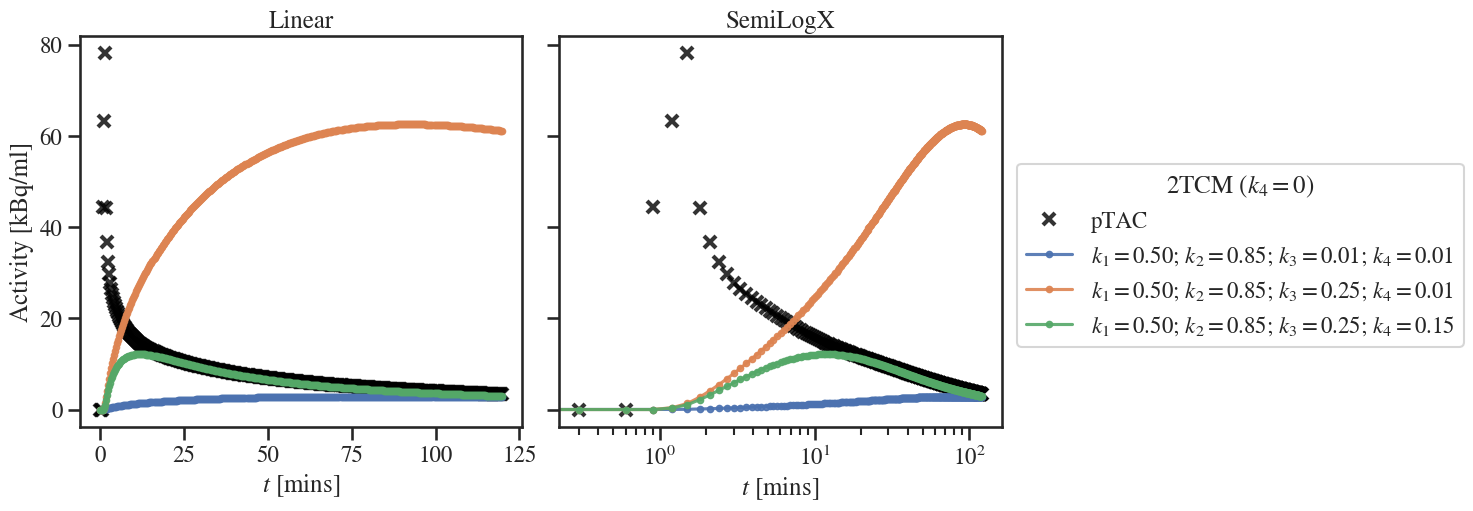

In [32]:
myFig, myAx = plt.subplots(1,2, figsize=[10,5], constrained_layout=True, sharey=True)
for anAx in myAx.flatten():
    anAx.plot(*interp_input, 'x', label='pTAC', color='black', alpha=0.8, mew=3)
    for kID, kVals in enumerate(zip(*TCM_FULL_2TCM_VALS_KVALS)):
        tcm_tac = pet_tcms.generate_tac_serial_2tcm_c2_from_tac(*interp_input, *kVals)
        anAx.plot(*tcm_tac, '.-', alpha=0.9, label=tcm_2tcm_label(*kVals))
myAx[0].set(ylabel="Activity [kBq/ml]", xlabel='$t$ [mins]', title='Linear')
myAx[1].set(xscale="log", xlabel='$t$ [mins]', title='SemiLogX')
myFig.legend(*myAx[0].get_legend_handles_labels(), bbox_to_anchor=(1.0, 0.5), loc='center left', title=r'2TCM ($k_4=0$)')
plt.show()

### $C_\mathrm{PET}$

#### Noise Free

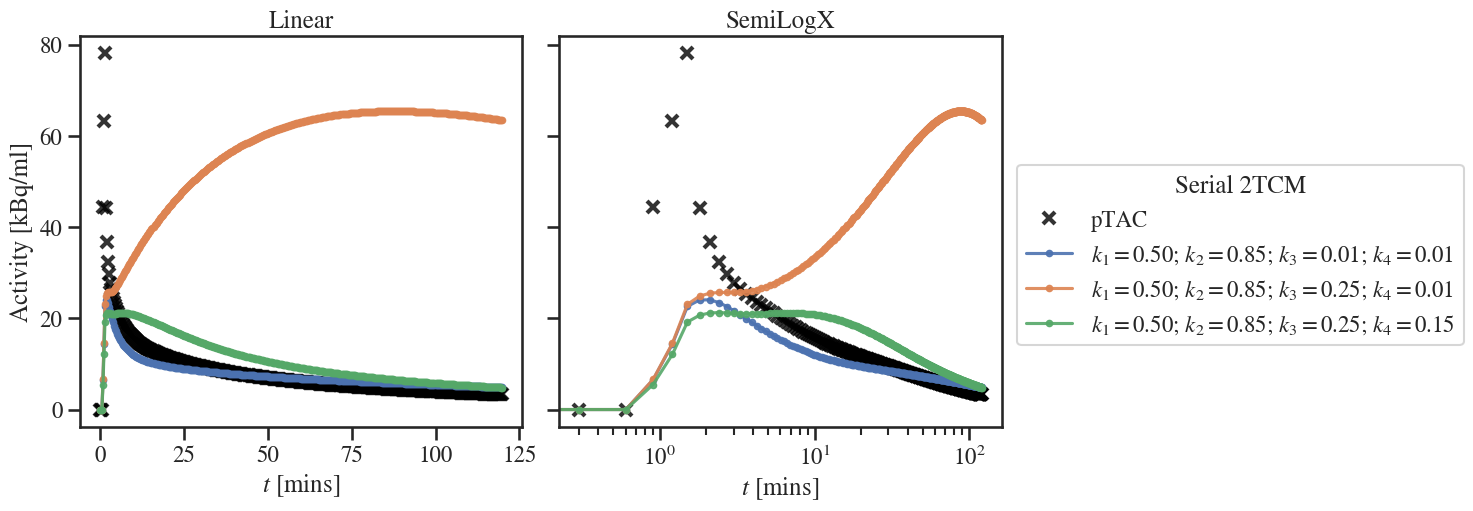

In [33]:
myFig, myAx = plt.subplots(1,2, figsize=[10,5], constrained_layout=True, sharey=True)
for anAx in myAx.flatten():
    anAx.plot(*interp_input, 'x', label='pTAC', color='black', alpha=0.8, mew=3)
    for kID, kVals in enumerate(zip(*TCM_FULL_2TCM_VALS_KVALS)):
        tcm_tac = pet_tcms.generate_tac_serial_2tcm_cpet_from_tac(*interp_input, *kVals)
        anAx.plot(*tcm_tac, '.-', alpha=0.9, label=tcm_2tcm_label(*kVals))
myAx[0].set(ylabel="Activity [kBq/ml]", xlabel='$t$ [mins]', title='Linear')
myAx[1].set(xscale="log", xlabel='$t$ [mins]', title='SemiLogX')
myFig.legend(*myAx[0].get_legend_handles_labels(), bbox_to_anchor=(1.0, 0.5), loc='center left', title=r'Serial 2TCM')
plt.savefig(f"serial_2tcm/noise_free/tacs.png", bbox_inches='tight', dpi=72)
plt.savefig(f"serial_2tcm/noise_free/tacs.pdf", bbox_inches='tight')
plt.show()

#### Gaussian Noise

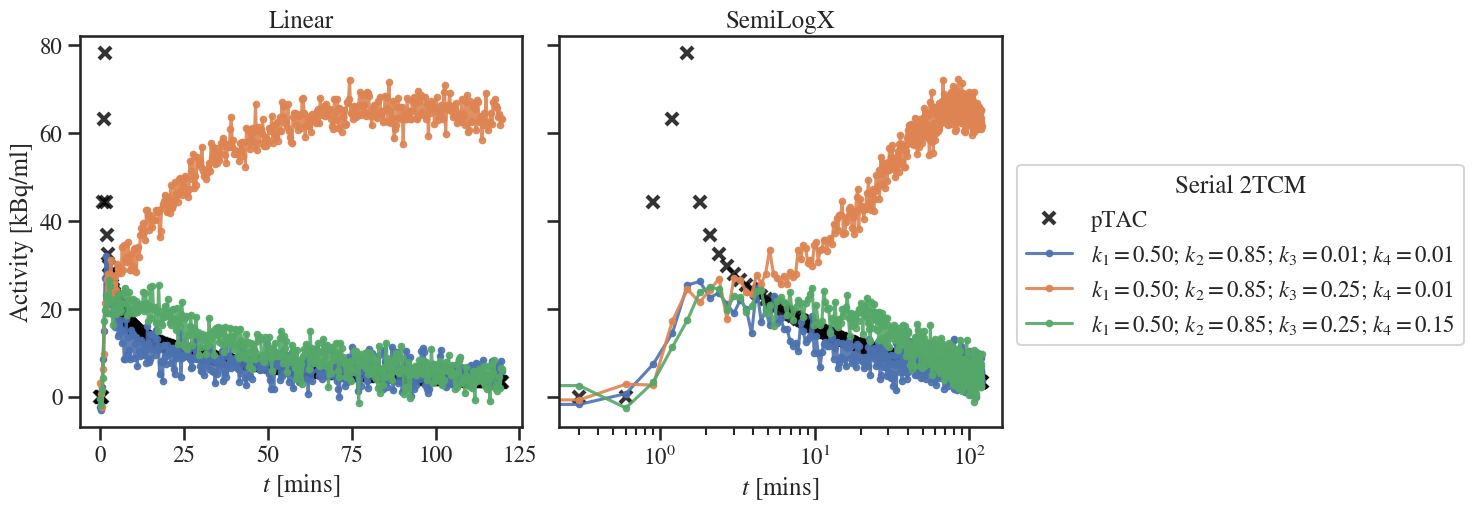

In [34]:
myFig, myAx = plt.subplots(1,2, figsize=[10,5], constrained_layout=True, sharey=True)
for anAx in myAx.flatten():
    anAx.plot(*interp_input, 'x', label='pTAC', color='black', alpha=0.8, mew=3)
    for kID, kVals in enumerate(zip(*TCM_FULL_2TCM_VALS_KVALS)):
        tcm_tac = pet_tcms.generate_tac_serial_2tcm_cpet_from_tac(*interp_input, *kVals)
        tcm_tac[1] += np.random.normal(loc=0.0, scale=noise_level, size=len(tcm_tac[1]))
        anAx.plot(*tcm_tac, '.-', alpha=0.9, label=tcm_2tcm_label(*kVals))
myAx[0].set(ylabel="Activity [kBq/ml]", xlabel='$t$ [mins]', title='Linear')
myAx[1].set(xscale="log", xlabel='$t$ [mins]', title='SemiLogX')
myFig.legend(*myAx[0].get_legend_handles_labels(), bbox_to_anchor=(1.0, 0.5), loc='center left', title=r'Serial 2TCM')
plt.savefig(f"serial_2tcm/gaussian_noise/tacs.png", bbox_inches='tight', dpi=72)
plt.savefig(f"serial_2tcm/gaussian_noise/tacs.pdf", bbox_inches='tight')
plt.show()

### $\partial_{t}C_\mathrm{PET}$

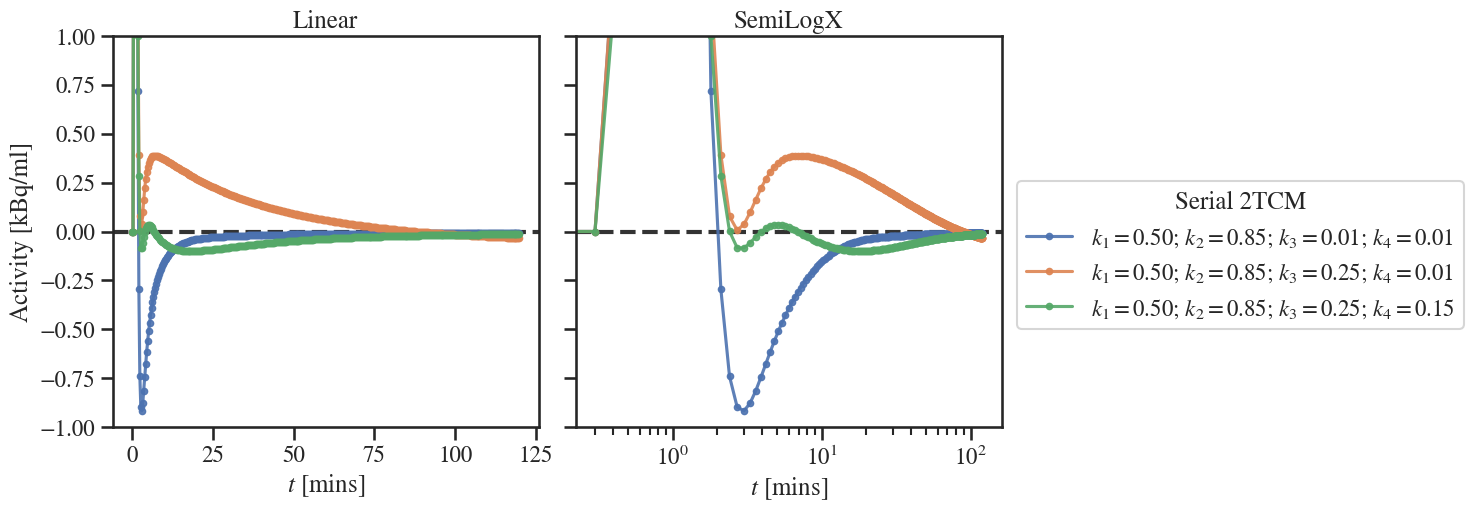

In [35]:
myFig, myAx = plt.subplots(1,2, figsize=[10,5], constrained_layout=True, sharey=True)
for anAx in myAx.flatten():
    anAx.axhline(0.0, ls='--', color='black', lw=3, alpha=0.8)
    for kID, kVals in enumerate(zip(*TCM_FULL_2TCM_VALS_KVALS)):
        tcm_tac = pet_tcms.generate_tac_serial_2tcm_cpet_from_tac(*interp_input, *kVals)
        anAx.plot(tcm_tac[0], np.gradient(tcm_tac[1]), '.-', alpha=0.9, label=tcm_2tcm_label(*kVals))
myAx[0].set(ylabel="Activity [kBq/ml]", xlabel='$t$ [mins]', title='Linear', ylim=(-1,1))
myAx[1].set(xscale="log", xlabel='$t$ [mins]', title='SemiLogX')
myFig.legend(*myAx[0].get_legend_handles_labels(), bbox_to_anchor=(1.0, 0.5), loc='center left', title=r'Serial 2TCM')
plt.show()

## Writing To Disk

### Noise Free

In [36]:
for pID, kVals in enumerate(zip(*TCM_FULL_2TCM_VALS_KVALS)):
    tcm_tac = pet_tcms.generate_tac_serial_2tcm_cpet_from_tac(*interp_input, *kVals)
    np.savetxt(f"serial_2tcm/noise_free/tac_2tcm_set-{pID:02}.txt", 
               fmt='%.6e',
               X=tcm_tac.T, 
               header=f"Serial 2TCM with {param_writer(kVals)}\nTimes[minutes] Activity[kBq/ml]")

### Gaussian Noise

In [37]:
for pID, kVals in enumerate(zip(*TCM_FULL_2TCM_VALS_KVALS)):
    tcm_tac = pet_tcms.generate_tac_serial_2tcm_cpet_from_tac(*interp_input, *kVals)
    tcm_tac[1] += np.random.normal(loc=0.0, scale=noise_level, size=len(tcm_tac[1]))
    np.savetxt(f"serial_2tcm/gaussian_noise/tac_2tcm_set-{pID:02}.txt", 
               fmt='%.6e',
               X=tcm_tac.T, 
               header=f"Serial 2TCM with {param_writer(kVals)}\nTimes[minutes] Activity[kBq/ml]")